In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import optim
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 불러오기
df_all2=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all2.iloc[:,[1,2,5]]

In [44]:
df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')

df_all

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


,date,price
0,2018-01-02,4104
1,2018-01-03,4049
2,2018-01-04,3920
3,2018-01-05,3917
4,2018-01-08,4090
...,...,...
999,2021-12-27,4825
1000,2021-12-28,4674
1001,2021-12-29,4904
1002,2021-12-30,5000


In [45]:
df['경락단가_평균']=df_all['price']

df_all

df.columns=['경락단가', '도매가격', 'day_sentiment']

df

df

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,경락단가,도매가격,day_sentiment
0,3750.366093,4104,0.000000
1,3547.574932,4049,0.000000
2,3696.060897,3920,-0.104167
3,3770.156364,3917,-0.104167
4,3815.720635,4090,-0.104167
...,...,...,...
863,4547.071429,5816,0.175000
864,4373.212544,5584,-0.116270
865,4278.649485,5723,-0.116270
866,4322.080986,5609,-0.116270


In [46]:
df_all

,date,price
0,2018-01-02,4104
1,2018-01-03,4049
2,2018-01-04,3920
3,2018-01-05,3917
4,2018-01-08,4090
...,...,...
999,2021-12-27,4825
1000,2021-12-28,4674
1001,2021-12-29,4904
1002,2021-12-30,5000


In [47]:
df_data=df[['도매가격','day_sentiment','도매가격']]
#df_data=df[['도매가격','도매가격']]
title='도매가격_도매가격'
term_np=np.array([])
MAE_np=np.array([])
MSE_np=np.array([])
RMSE_np=np.array([])
MAPE_np=np.array([])

In [48]:
CFG={'TRAIN_WINDOW_SIZE':13,
   'PREDICT_SIZE':3 ,
    'how_inputdim':2,
    'hidden_dim':10,
    'LEARNING_RATE':0.001,
    'nb_epochs':100,
    'BATCH_SIZE':25}
term="{}train_size-{}predict_size".format(CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE'])
print(term)

13train_size-3predict_size


In [49]:
# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
train_size = int(len(df)*0.7)
train_set = df_data[0:train_size]  
test_set = df_data[train_size-CFG['TRAIN_WINDOW_SIZE']:]

# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

# 데이터셋 생성 함수
def build_dataset(time_series,train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    dataX = []
    dataY = []
    window_size = train_size + predict_size
    for i in range(len(time_series) - window_size + 1):
        _x = time_series[i:i+train_size, :-1]
        _y = time_series[i+train_size:i+train_size+predict_size, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set))
testX, testY = build_dataset(np.array(test_set))

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

train_dataset = CustomDataset(trainX, trainY)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(testX, testY)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# test_dataset = CustomDataset(test_input, None)
# test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# 모델선언

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on 

In [50]:
# 데이터셋 생성 함수
def build_dataset(time_series,train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    dataX = []
    dataY = []
    window_size = train_size + predict_size
    for i in range(len(time_series) - window_size + 1):
        _x = time_series[i:i+train_size, :-1]
        _y = time_series[i+train_size:i+train_size+predict_size, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set))
testX, testY = build_dataset(np.array(test_set))

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

train_dataset = CustomDataset(trainX, trainY)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(testX, testY)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# test_dataset = CustomDataset(test_input, None)
# test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [380]:
# 모델선언

class BaseModel(nn.Module):
    def __init__(self, input_size=CFG['how_inputdim'], hidden_size=CFG['hidden_dim'], output_size=CFG['PREDICT_SIZE']):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size, output_size)
        )

        self.actv = nn.ReLU()

    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)

        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

In [381]:
# LSTM모델학습

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None

    for epoch in range(1, CFG['nb_epochs']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.squeeze())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y.squeeze())

            val_loss.append(loss.item())
    return np.mean(val_loss)

In [382]:
model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

def inference(model, test_loader, device):
    model.eval()
    predictions=[]
    with torch.no_grad():
        for X, Y in tqdm(iter(test_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            predictions.extend(output)

    return np.array(predictions)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.27643] Val Loss : [0.38879]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.25806] Val Loss : [0.36588]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.24605] Val Loss : [0.35186]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.24067] Val Loss : [0.34250]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.22553] Val Loss : [0.30266]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.19429] Val Loss : [0.24870]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.18660] Val Loss : [0.25142]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.17953] Val Loss : [0.24420]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.18574] Val Loss : [0.24471]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.18251] Val Loss : [0.24287]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.17974] Val Loss : [0.24245]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.18651] Val Loss : [0.24436]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.18363] Val Loss : [0.24276]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.17759] Val Loss : [0.24108]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.17291] Val Loss : [0.23885]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.17967] Val Loss : [0.23428]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.17434] Val Loss : [0.23106]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.17254] Val Loss : [0.19842]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.15354] Val Loss : [0.17807]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.11078] Val Loss : [0.06945]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.09294] Val Loss : [0.05503]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.07509] Val Loss : [0.03921]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.05782] Val Loss : [0.03613]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.05023] Val Loss : [0.03262]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.04710] Val Loss : [0.02959]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.03509] Val Loss : [0.02247]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.03360] Val Loss : [0.02363]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.03244] Val Loss : [0.02195]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.02802] Val Loss : [0.02230]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.02557] Val Loss : [0.01942]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.02475] Val Loss : [0.01463]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.02619] Val Loss : [0.01437]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.02451] Val Loss : [0.01914]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.02386] Val Loss : [0.01404]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.02245] Val Loss : [0.01738]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.02134] Val Loss : [0.01439]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.01920] Val Loss : [0.01420]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.01908] Val Loss : [0.01466]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.01850] Val Loss : [0.01425]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.02065] Val Loss : [0.01241]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.01788] Val Loss : [0.01227]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.01875] Val Loss : [0.01360]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.01731] Val Loss : [0.01134]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.01561] Val Loss : [0.00961]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.01703] Val Loss : [0.01216]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.01760] Val Loss : [0.01021]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.01499] Val Loss : [0.01037]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.01508] Val Loss : [0.00948]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.01700] Val Loss : [0.01073]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.01657] Val Loss : [0.01008]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.01472] Val Loss : [0.01117]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.01548] Val Loss : [0.01005]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.01416] Val Loss : [0.00885]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.01302] Val Loss : [0.00926]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.01298] Val Loss : [0.00871]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.01412] Val Loss : [0.00898]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.01277] Val Loss : [0.00740]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.01204] Val Loss : [0.00911]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.01317] Val Loss : [0.00935]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.01200] Val Loss : [0.00762]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.01225] Val Loss : [0.00743]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [62] Train Loss : [0.01307] Val Loss : [0.00948]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [63] Train Loss : [0.01206] Val Loss : [0.00776]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [64] Train Loss : [0.01216] Val Loss : [0.00955]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [65] Train Loss : [0.01175] Val Loss : [0.00833]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [66] Train Loss : [0.01107] Val Loss : [0.00856]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [67] Train Loss : [0.01217] Val Loss : [0.00761]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [68] Train Loss : [0.01151] Val Loss : [0.00703]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [69] Train Loss : [0.01176] Val Loss : [0.00718]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [70] Train Loss : [0.01132] Val Loss : [0.00772]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [71] Train Loss : [0.01184] Val Loss : [0.00739]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [72] Train Loss : [0.01131] Val Loss : [0.00669]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [73] Train Loss : [0.01236] Val Loss : [0.00681]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [74] Train Loss : [0.01157] Val Loss : [0.00721]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [75] Train Loss : [0.01149] Val Loss : [0.00683]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [76] Train Loss : [0.01106] Val Loss : [0.00666]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [77] Train Loss : [0.01181] Val Loss : [0.00750]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [78] Train Loss : [0.01108] Val Loss : [0.00649]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [79] Train Loss : [0.01064] Val Loss : [0.00614]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [80] Train Loss : [0.01051] Val Loss : [0.00639]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [81] Train Loss : [0.01008] Val Loss : [0.00733]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [82] Train Loss : [0.01025] Val Loss : [0.00632]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [83] Train Loss : [0.01008] Val Loss : [0.00575]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [84] Train Loss : [0.00950] Val Loss : [0.00650]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [85] Train Loss : [0.01062] Val Loss : [0.00599]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [86] Train Loss : [0.01000] Val Loss : [0.00719]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [87] Train Loss : [0.01003] Val Loss : [0.00595]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [88] Train Loss : [0.00999] Val Loss : [0.00614]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [89] Train Loss : [0.01005] Val Loss : [0.00677]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [90] Train Loss : [0.01038] Val Loss : [0.00616]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [91] Train Loss : [0.01115] Val Loss : [0.00661]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [92] Train Loss : [0.01175] Val Loss : [0.00747]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [93] Train Loss : [0.00992] Val Loss : [0.00677]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [94] Train Loss : [0.01103] Val Loss : [0.00701]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [95] Train Loss : [0.01034] Val Loss : [0.00639]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [96] Train Loss : [0.00952] Val Loss : [0.00637]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [97] Train Loss : [0.00850] Val Loss : [0.00643]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [98] Train Loss : [0.00973] Val Loss : [0.00517]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [99] Train Loss : [0.00925] Val Loss : [0.00602]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [100] Train Loss : [0.00958] Val Loss : [0.00583]


  0%|          | 0/11 [00:00<?, ?it/s]

(259, 3)
MAE SCORE :  254.01188842302125
MSE 94944.0052021685
RMSE 308.12985120265205
MAPE 5.175220339176756


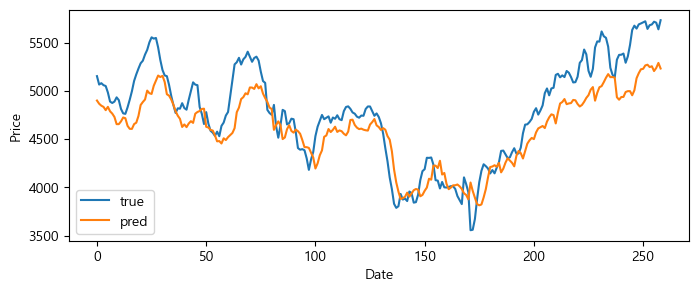

In [383]:
answer_np = np.empty((0,CFG['PREDICT_SIZE']))

for val in val_loader:
    answer_np = np.vstack((answer_np, val[1].view(-1,CFG['PREDICT_SIZE'])))

pred = inference(infer_model,val_loader , device)
print(pred.shape)

pred=scaler_y.inverse_transform(pred)

# 눤래 정답을 inverse scaling

answer_np=scaler_y.inverse_transform(answer_np)    
# 결과 후처리
answer_np = np.round(answer_np, 0).astype(int)
#print("answer_np", answer_np)

# 결과 출력
#MAE
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(answer_np, pred))
MAE_SCORE=MAE(answer_np, pred)

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(answer_np,pred))
MSE=mean_squared_error(answer_np,pred)
#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(answer_np,pred)
print("RMSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.
RMSE=np.sqrt(MSE)
#MAPE
import numpy as np

def MAPE(y_test, y_pred):
    return np.mean(np.abs((answer_np - pred) / answer_np)) * 100

print("MAPE",MAPE(answer_np, pred))
MAPE_SCORE=MAPE(answer_np, pred)

#결과값 데이터프레임으로 저장
term_np=np.append(term_np,term)
MAE_np=np.append(MAE_np,MAE_SCORE )
MSE_np=np.append(MSE_np,MSE )
RMSE_np=np.append(RMSE_np,RMSE )
MAPE_np=np.append(MAPE_np,MAPE_SCORE )

# 그래프 그리기
answer=np.mean(answer_np, axis=1)
prediction = np.mean(pred, axis=1)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(answer)), answer, label = 'true')
plt.plot(np.arange(len(prediction)), prediction, label = 'pred')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig("../결과/graph/{} {}train_size {}predict_size2.png".format(title,CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE']), dpi=300)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.26226] Val Loss : [0.36106]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.22921] Val Loss : [0.31972]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.20356] Val Loss : [0.28575]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.18321] Val Loss : [0.25674]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.17464] Val Loss : [0.23996]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.17096] Val Loss : [0.23126]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.16251] Val Loss : [0.22364]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.15860] Val Loss : [0.21777]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.15640] Val Loss : [0.21379]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.15406] Val Loss : [0.21046]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.15067] Val Loss : [0.20539]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.14947] Val Loss : [0.20243]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.14523] Val Loss : [0.19990]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.14367] Val Loss : [0.19442]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.13668] Val Loss : [0.18726]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.13815] Val Loss : [0.18554]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.13540] Val Loss : [0.18297]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.13306] Val Loss : [0.18336]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.13290] Val Loss : [0.18271]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.13149] Val Loss : [0.18175]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.13082] Val Loss : [0.17890]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.12873] Val Loss : [0.17644]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.12716] Val Loss : [0.17390]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.12772] Val Loss : [0.17474]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.12609] Val Loss : [0.17197]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.12416] Val Loss : [0.17213]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.12364] Val Loss : [0.17315]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.12378] Val Loss : [0.17087]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.12373] Val Loss : [0.16872]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.12147] Val Loss : [0.16942]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.12170] Val Loss : [0.16769]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.12272] Val Loss : [0.16800]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.12106] Val Loss : [0.17001]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.12163] Val Loss : [0.16712]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.12127] Val Loss : [0.16880]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.11994] Val Loss : [0.16811]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.12064] Val Loss : [0.16547]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.12050] Val Loss : [0.16694]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.12072] Val Loss : [0.16659]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.11996] Val Loss : [0.16677]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.11892] Val Loss : [0.16548]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.11871] Val Loss : [0.16624]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.11937] Val Loss : [0.16621]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.11877] Val Loss : [0.16576]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.11835] Val Loss : [0.16529]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.11922] Val Loss : [0.16553]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.11839] Val Loss : [0.16550]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.11878] Val Loss : [0.16619]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.11865] Val Loss : [0.16543]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.11804] Val Loss : [0.16427]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.11851] Val Loss : [0.16483]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.11867] Val Loss : [0.16486]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.11759] Val Loss : [0.16482]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.11800] Val Loss : [0.16438]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.11826] Val Loss : [0.16440]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.11830] Val Loss : [0.16501]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.11830] Val Loss : [0.16458]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.11858] Val Loss : [0.16415]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.11780] Val Loss : [0.16432]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.11871] Val Loss : [0.16499]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.11772] Val Loss : [0.16340]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [62] Train Loss : [0.11713] Val Loss : [0.16402]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [63] Train Loss : [0.11751] Val Loss : [0.16338]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [64] Train Loss : [0.11782] Val Loss : [0.16361]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [65] Train Loss : [0.11830] Val Loss : [0.16365]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [66] Train Loss : [0.11725] Val Loss : [0.16408]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [67] Train Loss : [0.11743] Val Loss : [0.16263]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [68] Train Loss : [0.11722] Val Loss : [0.16280]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [69] Train Loss : [0.11744] Val Loss : [0.16374]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [70] Train Loss : [0.11762] Val Loss : [0.16254]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [71] Train Loss : [0.11792] Val Loss : [0.16296]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [72] Train Loss : [0.11744] Val Loss : [0.16249]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [73] Train Loss : [0.11713] Val Loss : [0.16271]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [74] Train Loss : [0.11795] Val Loss : [0.16295]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [75] Train Loss : [0.11773] Val Loss : [0.16319]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [76] Train Loss : [0.11680] Val Loss : [0.16274]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [77] Train Loss : [0.11730] Val Loss : [0.16304]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [78] Train Loss : [0.11694] Val Loss : [0.16266]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [79] Train Loss : [0.11687] Val Loss : [0.16430]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [80] Train Loss : [0.11730] Val Loss : [0.16250]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [81] Train Loss : [0.11709] Val Loss : [0.16182]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [82] Train Loss : [0.11721] Val Loss : [0.16256]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [83] Train Loss : [0.11687] Val Loss : [0.16265]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [84] Train Loss : [0.11594] Val Loss : [0.16243]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [85] Train Loss : [0.11699] Val Loss : [0.16268]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [86] Train Loss : [0.11704] Val Loss : [0.16267]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [87] Train Loss : [0.11746] Val Loss : [0.16322]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [88] Train Loss : [0.11701] Val Loss : [0.16227]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [89] Train Loss : [0.11680] Val Loss : [0.16271]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [90] Train Loss : [0.11688] Val Loss : [0.16261]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [91] Train Loss : [0.11701] Val Loss : [0.16270]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [92] Train Loss : [0.11716] Val Loss : [0.16306]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [93] Train Loss : [0.11743] Val Loss : [0.16286]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [94] Train Loss : [0.11675] Val Loss : [0.16253]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [95] Train Loss : [0.11731] Val Loss : [0.16184]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [96] Train Loss : [0.11663] Val Loss : [0.16315]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [97] Train Loss : [0.11686] Val Loss : [0.16199]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [98] Train Loss : [0.11666] Val Loss : [0.16205]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [99] Train Loss : [0.11689] Val Loss : [0.16182]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [100] Train Loss : [0.11636] Val Loss : [0.16291]


  0%|          | 0/11 [00:00<?, ?it/s]

(259, 3)
answer_np [[5251 5108 5101]
 [5108 5101 4990]
 [5101 4990 5150]
 [4990 5150 5039]
 [5150 5039 4964]
 [5039 4964 4948]
 [4964 4948 4756]
 [4948 4756 4921]
 [4756 4921 4992]
 [4921 4992 4887]
 [4992 4887 4835]
 [4887 4835 4718]
 [4835 4718 4749]
 [4718 4749 4820]
 [4749 4820 4919]
 [4820 4919 4988]
 [4919 4988 5084]
 [4988 5084 5238]
 [5084 5238 5194]
 [5238 5194 5264]
 [5194 5264 5402]
 [5264 5402 5274]
 [5402 5274 5454]
 [5274 5454 5549]
 [5454 5549 5507]
 [5549 5507 5611]
 [5507 5611 5509]
 [5611 5509 5527]
 [5509 5527 5317]
 [5527 5317 5118]
 [5317 5118 5216]
 [5118 5216 5148]
 [5216 5148 5095]
 [5148 5095 4944]
 [5095 4944 4806]
 [4944 4806 4810]
 [4806 4810 4699]
 [4810 4699 4950]
 [4699 4950 4799]
 [4950 4799 4870]
 [4799 4870 4798]
 [4870 4798 4749]
 [4798 4749 5176]
 [4749 5176 5069]
 [5176 5069 5022]
 [5069 5022 5105]
 [5022 5105 5052]
 [5105 5052 4345]
 [5052 4345 4891]
 [4345 4891 4734]
 [4891 4734 4717]
 [4734 4717 4531]
 [4717 4531 4513]
 [4531 4513 4658]
 [4513 46

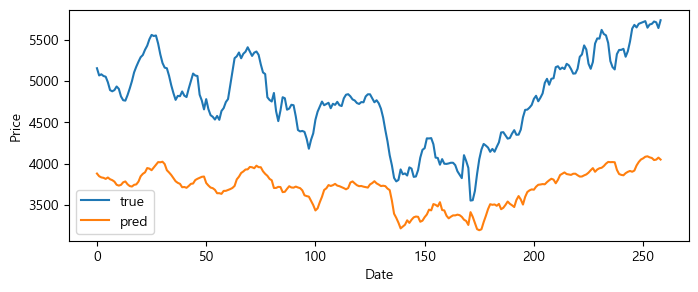

In [9]:
class BaseModel(nn.Module):
    def __init__(self, input_size=CFG['how_inputdim'], hidden_size=CFG['hidden_dim'], output_size=CFG['PREDICT_SIZE']):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size, output_size)
        )

        self.actv = nn.ReLU()

    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)

        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# LSTM모델학습

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None

    for epoch in range(1, CFG['nb_epochs']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.squeeze())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y.squeeze())

            val_loss.append(loss.item())
    return np.mean(val_loss)

model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

def inference(model, test_loader, device):
    model.eval()
    predictions=[]
    with torch.no_grad():
        for X, Y in tqdm(iter(test_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            predictions.extend(output)

    return np.array(predictions)

answer_np = np.empty((0,CFG['PREDICT_SIZE']))

for val in val_loader:
    answer_np = np.vstack((answer_np, val[1].view(-1,CFG['PREDICT_SIZE'])))

pred = inference(infer_model,val_loader , device)
print(pred.shape)

pred=scaler_y.inverse_transform(pred)

# 눤래 정답을 inverse scaling

answer_np=scaler_y.inverse_transform(answer_np)    
# 결과 후처리
answer_np = np.round(answer_np, 0).astype(int)
print("answer_np", answer_np)

# 결과 출력
#MAE
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(answer_np, pred))
MAE_SCORE=MAE(answer_np, pred)

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(answer_np,pred))
MSE=mean_squared_error(answer_np,pred)
#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(answer_np,pred)
print("RMSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.
RMSE=np.sqrt(MSE)
#MAPE
import numpy as np

def MAPE(y_test, y_pred):
    return np.mean(np.abs((answer_np - pred) / answer_np)) * 100

print("MAPE",MAPE(answer_np, pred))
MAPE_SCORE=MAPE(answer_np, pred)

#결과값 데이터프레임으로 저장
term_np=np.append(term_np,term)
MAE_np=np.append(MAE_np,MAE_SCORE )
MSE_np=np.append(MSE_np,MSE )
RMSE_np=np.append(RMSE_np,RMSE )
MAPE_np=np.append(MAPE_np,MAPE_SCORE )

# 그래프 그리기
answer=np.mean(answer_np, axis=1)
prediction = np.mean(pred, axis=1)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(answer)), answer, label = 'true')
plt.plot(np.arange(len(prediction)), prediction, label = 'pred')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig("../결과/graph/{} {}train_size {}predict_size2.png".format(title,CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE']), dpi=300)

In [394]:
np.save('./prediction_lstm',prediction) # x_save.npy

### 결과 저장

In [385]:
df_result=pd.DataFrame()

In [386]:
df_result['term']=term_np
df_result['MAE']=MAE_np
df_result['MSE']=MSE_np
df_result['RMSE']=RMSE_np
df_result['MAPE']=MAPE_np

In [387]:
df_result.to_csv("../결과/result/result_13_3.csv".format(title,CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE']),encoding="utf-8")

In [388]:
answer_np.shape

(259, 3)

In [389]:
pred.shape

(259, 3)

In [390]:
 for val in val_loader:
    print(val[0])


tensor([[[0.7742, 0.8011],
         [0.7400, 0.6687],
         [0.7995, 0.6802],
         [0.8019, 0.7208],
         [0.7854, 0.7208],
         [0.7598, 0.8021],
         [0.7931, 0.8021],
         [0.8124, 0.7163],
         [0.8153, 0.7163],
         [0.8153, 0.7163],
         [0.7608, 0.7708],
         [0.7146, 0.7454],
         [0.7799, 0.7361]],

        [[0.7400, 0.6687],
         [0.7995, 0.6802],
         [0.8019, 0.7208],
         [0.7854, 0.7208],
         [0.7598, 0.8021],
         [0.7931, 0.8021],
         [0.8124, 0.7163],
         [0.8153, 0.7163],
         [0.8153, 0.7163],
         [0.7608, 0.7708],
         [0.7146, 0.7454],
         [0.7799, 0.7361],
         [0.7727, 0.5000]],

        [[0.7995, 0.6802],
         [0.8019, 0.7208],
         [0.7854, 0.7208],
         [0.7598, 0.8021],
         [0.7931, 0.8021],
         [0.8124, 0.7163],
         [0.8153, 0.7163],
         [0.8153, 0.7163],
         [0.7608, 0.7708],
         [0.7146, 0.7454],
         [0.7799, 0.7361

In [52]:
best_model=None

### GRU test

In [65]:
# 모델선언

class BaseGRUModel(nn.Module):
    def __init__(self, input_size=CFG['how_inputdim'], hidden_size=CFG['hidden_dim'], output_size=CFG['PREDICT_SIZE']):
        super(BaseGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # GRU layer
        gru_out, hidden = self.gru(x, hidden)

        # Only use the last output sequence
        last_output = gru_out[:, -1, :]
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden stat
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
# 모델학습

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None

    for epoch in range(1, CFG['nb_epochs']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.squeeze())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y.squeeze())

            val_loss.append(loss.item())
    return np.mean(val_loss)

model = BaseGRUModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

def inference(model, test_loader, device):
    model.eval()
    predictions=[]
    with torch.no_grad():
        for X, Y in tqdm(iter(test_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            predictions.extend(output)

    return np.array(predictions)

answer_np = np.empty((0,CFG['PREDICT_SIZE']))

for val in val_loader:
    answer_np = np.vstack((answer_np, val[1].view(-1,CFG['PREDICT_SIZE'])))

pred = inference(infer_model,val_loader , device)
print(pred.shape)

pred=scaler_y.inverse_transform(pred)

# 눤래 정답을 inverse scaling

answer_np=scaler_y.inverse_transform(answer_np)    
# 결과 후처리
answer_np = np.round(answer_np, 0).astype(int)
print("answer_np", answer_np)

# 결과 출력
#MAE
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(answer_np, pred))
MAE_SCORE=MAE(answer_np, pred)

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(answer_np,pred))
MSE=mean_squared_error(answer_np,pred)
#RMSE

import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(answer_np,pred)
print("RMSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.
RMSE=np.sqrt(MSE)
#MAPE
import numpy as np

def MAPE(y_test, y_pred):
    return np.mean(np.abs((answer_np - pred) / answer_np)) * 100

print("MAPE",MAPE(answer_np, pred))
MAPE_SCORE=MAPE(answer_np, pred)

#결과값 데이터프레임으로 저장
term_np=np.append(term_np,term)
MAE_np=np.append(MAE_np,MAE_SCORE )
MSE_np=np.append(MSE_np,MSE )
RMSE_np=np.append(RMSE_np,RMSE )
MAPE_np=np.append(MAPE_np,MAPE_SCORE )

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.29735] Val Loss : [0.41451]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.27636] Val Loss : [0.39228]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.25593] Val Loss : [0.36339]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.21929] Val Loss : [0.29674]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.19191] Val Loss : [0.25911]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.17648] Val Loss : [0.26270]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.15914] Val Loss : [0.24227]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.15214] Val Loss : [0.18769]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.12907] Val Loss : [0.14912]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.12589] Val Loss : [0.13335]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.12199] Val Loss : [0.12306]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.10520] Val Loss : [0.10577]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.09173] Val Loss : [0.08666]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.09220] Val Loss : [0.07815]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.07614] Val Loss : [0.06739]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.06665] Val Loss : [0.06279]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.06755] Val Loss : [0.05713]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.05584] Val Loss : [0.05308]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.05472] Val Loss : [0.05256]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.04727] Val Loss : [0.04954]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.04559] Val Loss : [0.04472]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.04448] Val Loss : [0.04613]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.04081] Val Loss : [0.04273]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.03727] Val Loss : [0.03933]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.03907] Val Loss : [0.03768]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.03655] Val Loss : [0.04049]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.03412] Val Loss : [0.03740]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.03519] Val Loss : [0.03514]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.03047] Val Loss : [0.03151]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.02949] Val Loss : [0.03266]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.03102] Val Loss : [0.02968]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.02807] Val Loss : [0.02933]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.02588] Val Loss : [0.02712]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.02306] Val Loss : [0.02369]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.02486] Val Loss : [0.02262]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.02073] Val Loss : [0.02288]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.02179] Val Loss : [0.01944]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.02058] Val Loss : [0.01704]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.01951] Val Loss : [0.01682]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.01862] Val Loss : [0.01651]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.01804] Val Loss : [0.01569]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.01801] Val Loss : [0.01454]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.01818] Val Loss : [0.01472]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.01795] Val Loss : [0.01510]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.01748] Val Loss : [0.01276]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.01483] Val Loss : [0.01195]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.01622] Val Loss : [0.01174]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.01557] Val Loss : [0.01134]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.01732] Val Loss : [0.01356]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.01500] Val Loss : [0.01158]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.01694] Val Loss : [0.01263]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.01393] Val Loss : [0.01049]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.01571] Val Loss : [0.01214]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.01544] Val Loss : [0.01055]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.01574] Val Loss : [0.01147]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.01506] Val Loss : [0.00875]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.01506] Val Loss : [0.01111]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.01529] Val Loss : [0.01104]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.01417] Val Loss : [0.00889]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.01544] Val Loss : [0.01034]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.01512] Val Loss : [0.00998]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [62] Train Loss : [0.01445] Val Loss : [0.01137]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [63] Train Loss : [0.01394] Val Loss : [0.00800]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [64] Train Loss : [0.01624] Val Loss : [0.01049]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [65] Train Loss : [0.01577] Val Loss : [0.01064]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [66] Train Loss : [0.01539] Val Loss : [0.00895]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [67] Train Loss : [0.01444] Val Loss : [0.00987]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [68] Train Loss : [0.01614] Val Loss : [0.00940]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [69] Train Loss : [0.01556] Val Loss : [0.00918]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [70] Train Loss : [0.01474] Val Loss : [0.00935]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [71] Train Loss : [0.01509] Val Loss : [0.00855]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [72] Train Loss : [0.01414] Val Loss : [0.00854]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [73] Train Loss : [0.01653] Val Loss : [0.00859]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [74] Train Loss : [0.01519] Val Loss : [0.00848]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [75] Train Loss : [0.01500] Val Loss : [0.00880]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [76] Train Loss : [0.01530] Val Loss : [0.00883]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [77] Train Loss : [0.01419] Val Loss : [0.00913]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [78] Train Loss : [0.01402] Val Loss : [0.00754]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [79] Train Loss : [0.01429] Val Loss : [0.00772]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [80] Train Loss : [0.01586] Val Loss : [0.00891]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [81] Train Loss : [0.01476] Val Loss : [0.00936]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [82] Train Loss : [0.01481] Val Loss : [0.01028]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [83] Train Loss : [0.01432] Val Loss : [0.00900]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [84] Train Loss : [0.01350] Val Loss : [0.00793]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [85] Train Loss : [0.01376] Val Loss : [0.00752]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [86] Train Loss : [0.01335] Val Loss : [0.00750]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [87] Train Loss : [0.01353] Val Loss : [0.00879]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [88] Train Loss : [0.01417] Val Loss : [0.00848]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [89] Train Loss : [0.01427] Val Loss : [0.00989]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [90] Train Loss : [0.01483] Val Loss : [0.00773]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [91] Train Loss : [0.01510] Val Loss : [0.00850]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [92] Train Loss : [0.01419] Val Loss : [0.00802]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [93] Train Loss : [0.01452] Val Loss : [0.00847]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [94] Train Loss : [0.01428] Val Loss : [0.00744]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [95] Train Loss : [0.01539] Val Loss : [0.00808]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [96] Train Loss : [0.01454] Val Loss : [0.00975]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [97] Train Loss : [0.01604] Val Loss : [0.00766]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [98] Train Loss : [0.01450] Val Loss : [0.00761]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [99] Train Loss : [0.01428] Val Loss : [0.00954]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [100] Train Loss : [0.01370] Val Loss : [0.00759]


  0%|          | 0/11 [00:00<?, ?it/s]

(259, 3)
answer_np [[5251 5108 5101]
 [5108 5101 4990]
 [5101 4990 5150]
 [4990 5150 5039]
 [5150 5039 4964]
 [5039 4964 4948]
 [4964 4948 4756]
 [4948 4756 4921]
 [4756 4921 4992]
 [4921 4992 4887]
 [4992 4887 4835]
 [4887 4835 4718]
 [4835 4718 4749]
 [4718 4749 4820]
 [4749 4820 4919]
 [4820 4919 4988]
 [4919 4988 5084]
 [4988 5084 5238]
 [5084 5238 5194]
 [5238 5194 5264]
 [5194 5264 5402]
 [5264 5402 5274]
 [5402 5274 5454]
 [5274 5454 5549]
 [5454 5549 5507]
 [5549 5507 5611]
 [5507 5611 5509]
 [5611 5509 5527]
 [5509 5527 5317]
 [5527 5317 5118]
 [5317 5118 5216]
 [5118 5216 5148]
 [5216 5148 5095]
 [5148 5095 4944]
 [5095 4944 4806]
 [4944 4806 4810]
 [4806 4810 4699]
 [4810 4699 4950]
 [4699 4950 4799]
 [4950 4799 4870]
 [4799 4870 4798]
 [4870 4798 4749]
 [4798 4749 5176]
 [4749 5176 5069]
 [5176 5069 5022]
 [5069 5022 5105]
 [5022 5105 5052]
 [5105 5052 4345]
 [5052 4345 4891]
 [4345 4891 4734]
 [4891 4734 4717]
 [4734 4717 4531]
 [4717 4531 4513]
 [4531 4513 4658]
 [4513 46

In [66]:
prediction2=np.load('./prediction_lstm.npy') # 데이터 로드. @파일명

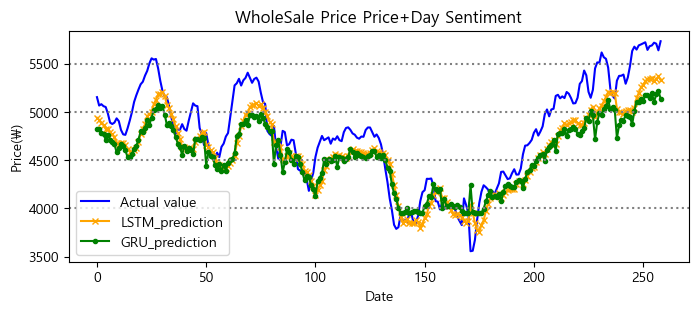

In [68]:
# 그래프 그리기
answer=np.mean(answer_np, axis=1)
GRU_prediction = np.mean(pred, axis=1)
#x = df_all['판정일']
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(answer)), answer,'b', label = 'Actual value')
plt.plot(np.arange(len(prediction2)),prediction2,color='orange',marker='x',markersize=4,label = 'LSTM_prediction')
plt.plot(np.arange(len(prediction)), GRU_prediction,color='green' ,marker='o',markersize=3,label = 'GRU_prediction')
plt.legend()
title='WholeSale Price Price+Day Sentiment'
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Price(\)')
# 1000 단위로 수평선 그리기
for y_value in np.arange(4000, 6000, 500):
    plt.axhline(y=y_value, color='gray', linestyle=':')

plt.savefig("../결과/LSTM_GRU/{} {}train_size {}predict_size.png".format(title,CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE']),dpi=2000)

# 감성점수만으로 도매가격 예측했을때

In [334]:
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')

df_all

df['경락단가_평균']=df_all['price']

df_all

df.columns=['경락단가', '도매가격', 'day_sentiment']

df

df

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """


,경락단가,도매가격,day_sentiment
0,3750.366093,4104,0.000000
1,3547.574932,4049,0.000000
2,3696.060897,3920,-0.104167
3,3770.156364,3917,-0.104167
4,3815.720635,4090,-0.104167
...,...,...,...
863,4547.071429,5816,0.175000
864,4373.212544,5584,-0.116270
865,4278.649485,5723,-0.116270
866,4322.080986,5609,-0.116270


In [335]:
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]
df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')
df['경락단가_평균']=df_all['price']
df.columns=['경락단가', '도매가격', 'day_sentiment']

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  after removing the cwd from sys.path.


In [336]:
df_data=df[['day_sentiment','도매가격']]
#df_data=df[['도매가격','도매가격']]
title='도매가격'
term_np=np.array([])
MAE_np=np.array([])
MSE_np=np.array([])
RMSE_np=np.array([])
MAPE_np=np.array([])

In [337]:
CFG={'TRAIN_WINDOW_SIZE':13,
   'PREDICT_SIZE':3 ,
    'how_inputdim':1,
    'hidden_dim':10,
    'LEARNING_RATE':0.001,
    'nb_epochs':100,
    'BATCH_SIZE':25}
term="{}train_size-{}predict_size".format(CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE'])
print(term)

13train_size-3predict_size


# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용

In [338]:
from sklearn.preprocessing import StandardScaler
train_size = int(len(df)*0.7)
train_set = df_data[0:train_size]  
test_set = df_data[train_size-CFG['TRAIN_WINDOW_SIZE']:]

In [339]:
# Input scale
# scaler_x = MinMaxScaler()
# scaler_x.fit(train_set.iloc[:, :-1])

# train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
# test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])
# 조건에 따라 로그 변환 적용
train_set['day_sentiment'] = train_set['day_sentiment'].apply(lambda x: -np.log(-x) if x < 0 else np.log(x) if x != 0 else 0)
test_set['day_sentiment'] = test_set['day_sentiment'].apply(lambda x: -np.log(-x) if x < 0 else np.log(x) if x != 0 else 0)


print("test_set.iloc[:, :-1]",type(test_set.iloc[:, :-1]))
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1:] = scaler_y.transform(train_set.iloc[:, -1:])
test_set.iloc[:, -1:] = scaler_y.transform(test_set.iloc[:, -1:])

print("train_set",train_set)
# 데이터셋 생성 함수
def build_dataset(time_series,train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    dataX = []
    dataY = []
    window_size = train_size + predict_size
    for i in range(len(time_series) - window_size + 1):
        _x = time_series[i:i+train_size, :-1]
        _y = time_series[i+train_size:i+train_size+predict_size, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set))
testX, testY = build_dataset(np.array(test_set))

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

train_dataset = CustomDataset(trainX, trainY)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(testX, testY)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# test_dataset = CustomDataset(test_input, None)
# test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# 모델선언

test_set.iloc[:, :-1] <class 'pandas.core.frame.DataFrame'>
train_set      day_sentiment      도매가격
0         0.000000  0.498325
1         0.000000  0.485167
2         2.261763  0.454306
3         2.261763  0.453589
4         2.261763  0.494976
..             ...       ...
602       0.694680  0.815311
603       0.694680  0.815311
604      -0.910235  0.760766
605       1.383537  0.714593
606       1.061385  0.779904

[607 rows x 2 columns]


C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [340]:
class BaseModel(nn.Module):
    def __init__(self, input_size=CFG['how_inputdim'], hidden_size=CFG['hidden_dim'], output_size=CFG['PREDICT_SIZE']):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size, output_size)
        )

        self.actv = nn.ReLU()

    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)

        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# LSTM모델학습

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999999999999999999
    best_model = None

    for epoch in range(1, CFG['nb_epochs']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.squeeze())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y.squeeze())

            val_loss.append(loss.item())
    return np.mean(val_loss)

model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

def inference(model, test_loader, device):
    model.eval()
    predictions=[]
    with torch.no_grad():
        for X, Y in tqdm(iter(test_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            predictions.extend(output)

    return np.array(predictions)

answer_np = np.empty((0,CFG['PREDICT_SIZE']))

for val in val_loader:
    answer_np = np.vstack((answer_np, val[1].view(-1,CFG['PREDICT_SIZE'])))

pred = inference(infer_model,val_loader , device)

pred=scaler_y.inverse_transform(pred)
print(pred)

# 눤래 정답을 inverse scaling

answer_np=scaler_y.inverse_transform(answer_np)    
# 결과 후처리
answer_np = np.round(answer_np, 0).astype(int)
print("answer_np", answer_np)

# 결과 출력
#MAE
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(answer_np, pred))
MAE_SCORE=MAE(answer_np, pred)

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(answer_np,pred))
MSE=mean_squared_error(answer_np,pred)
#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(answer_np,pred)
print("RMSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.
RMSE=np.sqrt(MSE)
#MAPE
import numpy as np

def MAPE(y_test, y_pred):
    return np.mean(np.abs((answer_np - pred) / answer_np)) * 100

print("MAPE",MAPE(answer_np, pred))
MAPE_SCORE=MAPE(answer_np, pred)

#결과값 데이터프레임으로 저장
term_np=np.append(term_np,term)
MAE_np=np.append(MAE_np,MAE_SCORE )
MSE_np=np.append(MSE_np,MSE )
RMSE_np=np.append(RMSE_np,RMSE )
MAPE_np=np.append(MAPE_np,MAPE_SCORE )

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.13518] Val Loss : [0.17594]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.09818] Val Loss : [0.11375]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.07523] Val Loss : [0.07873]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.06215] Val Loss : [0.06402]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.05473] Val Loss : [0.05774]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.05203] Val Loss : [0.05480]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.04833] Val Loss : [0.05146]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.04671] Val Loss : [0.05088]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.04797] Val Loss : [0.05064]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.04572] Val Loss : [0.05026]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.04699] Val Loss : [0.05168]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.04482] Val Loss : [0.05095]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.04078] Val Loss : [0.04887]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.03796] Val Loss : [0.04745]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.04191] Val Loss : [0.04765]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.04104] Val Loss : [0.04772]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.04160] Val Loss : [0.04718]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.04145] Val Loss : [0.04721]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.03905] Val Loss : [0.04710]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.03935] Val Loss : [0.04500]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.03988] Val Loss : [0.04497]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.03790] Val Loss : [0.04523]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.03664] Val Loss : [0.04428]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.03768] Val Loss : [0.04439]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.03548] Val Loss : [0.04437]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.03656] Val Loss : [0.04432]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.03714] Val Loss : [0.04415]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.03497] Val Loss : [0.04371]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.03444] Val Loss : [0.04251]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.03399] Val Loss : [0.04203]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.03509] Val Loss : [0.04209]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.03355] Val Loss : [0.04214]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.03311] Val Loss : [0.04174]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.03246] Val Loss : [0.04170]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.03236] Val Loss : [0.04104]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.03300] Val Loss : [0.04139]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.03394] Val Loss : [0.04199]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.03187] Val Loss : [0.04181]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.03113] Val Loss : [0.04035]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.03084] Val Loss : [0.03959]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.03305] Val Loss : [0.04031]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.03142] Val Loss : [0.04052]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.03208] Val Loss : [0.04016]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.03148] Val Loss : [0.04023]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.03078] Val Loss : [0.03951]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.03065] Val Loss : [0.03939]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.03109] Val Loss : [0.03882]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.03053] Val Loss : [0.03906]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.03068] Val Loss : [0.03943]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.02951] Val Loss : [0.03874]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.03089] Val Loss : [0.03862]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.03110] Val Loss : [0.03893]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.03120] Val Loss : [0.03973]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.03044] Val Loss : [0.03951]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.02988] Val Loss : [0.03885]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.03036] Val Loss : [0.03865]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.02987] Val Loss : [0.03855]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.02895] Val Loss : [0.03762]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.02992] Val Loss : [0.03754]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.02971] Val Loss : [0.03778]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.02929] Val Loss : [0.03792]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [62] Train Loss : [0.02951] Val Loss : [0.03790]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [63] Train Loss : [0.02936] Val Loss : [0.03784]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [64] Train Loss : [0.02867] Val Loss : [0.03726]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [65] Train Loss : [0.02956] Val Loss : [0.03680]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [66] Train Loss : [0.02870] Val Loss : [0.03678]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [67] Train Loss : [0.02945] Val Loss : [0.03727]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [68] Train Loss : [0.02905] Val Loss : [0.03736]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [69] Train Loss : [0.02906] Val Loss : [0.03705]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [70] Train Loss : [0.02821] Val Loss : [0.03684]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [71] Train Loss : [0.02879] Val Loss : [0.03682]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [72] Train Loss : [0.02892] Val Loss : [0.03661]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [73] Train Loss : [0.02875] Val Loss : [0.03699]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [74] Train Loss : [0.02846] Val Loss : [0.03679]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [75] Train Loss : [0.02883] Val Loss : [0.03696]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [76] Train Loss : [0.02919] Val Loss : [0.03726]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [77] Train Loss : [0.02882] Val Loss : [0.03748]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [78] Train Loss : [0.02856] Val Loss : [0.03710]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [79] Train Loss : [0.02905] Val Loss : [0.03700]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [80] Train Loss : [0.02865] Val Loss : [0.03698]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [81] Train Loss : [0.02867] Val Loss : [0.03685]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [82] Train Loss : [0.02887] Val Loss : [0.03699]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [83] Train Loss : [0.02867] Val Loss : [0.03675]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [84] Train Loss : [0.02854] Val Loss : [0.03663]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [85] Train Loss : [0.02884] Val Loss : [0.03694]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [86] Train Loss : [0.02818] Val Loss : [0.03698]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [87] Train Loss : [0.02825] Val Loss : [0.03644]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [88] Train Loss : [0.02870] Val Loss : [0.03658]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [89] Train Loss : [0.02863] Val Loss : [0.03661]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [90] Train Loss : [0.02864] Val Loss : [0.03683]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [91] Train Loss : [0.02860] Val Loss : [0.03656]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [92] Train Loss : [0.02854] Val Loss : [0.03669]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [93] Train Loss : [0.02858] Val Loss : [0.03666]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [94] Train Loss : [0.02848] Val Loss : [0.03623]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [95] Train Loss : [0.02825] Val Loss : [0.03613]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [96] Train Loss : [0.02826] Val Loss : [0.03601]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [97] Train Loss : [0.02862] Val Loss : [0.03591]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [98] Train Loss : [0.02828] Val Loss : [0.03570]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [99] Train Loss : [0.02815] Val Loss : [0.03551]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [100] Train Loss : [0.02812] Val Loss : [0.03533]
Model Saved


  0%|          | 0/11 [00:00<?, ?it/s]

[[4304.7725 4313.153  4304.395 ]
 [4319.7524 4329.8066 4330.403 ]
 [4328.1973 4338.32   4346.3594]
 [4312.739  4324.5635 4320.3633]
 [4290.434  4304.9497 4282.222 ]
 [4275.8604 4293.624  4257.198 ]
 [4272.491  4291.5537 4251.51  ]
 [4264.738  4282.1914 4238.7207]
 [4257.962  4264.527  4221.322 ]
 [4275.67   4280.3403 4258.3506]
 [4252.5415 4262.996  4229.916 ]
 [4246.4775 4259.232  4212.67  ]
 [4300.5205 4315.3447 4296.4507]
 [4335.984  4346.431  4358.612 ]
 [4316.6045 4323.41   4325.994 ]
 [4324.506  4333.97   4339.828 ]
 [4329.2393 4339.1133 4347.62  ]
 [4322.83   4331.828  4337.966 ]
 [4311.912  4321.079  4319.345 ]
 [4286.5234 4268.8853 4275.998 ]
 [4266.6846 4268.96   4237.766 ]
 [4261.951  4273.77   4230.076 ]
 [4267.8677 4275.093  4241.3457]
 [4282.967  4294.263  4272.2554]
 [4289.1445 4295.9478 4278.774 ]
 [4298.0664 4307.3906 4293.6387]
 [4316.0186 4326.2783 4324.2056]
 [4311.126  4317.2935 4318.101 ]
 [4265.283  4267.2725 4235.6733]
 [4282.7026 4291.7456 4270.0186]
 [4274.274

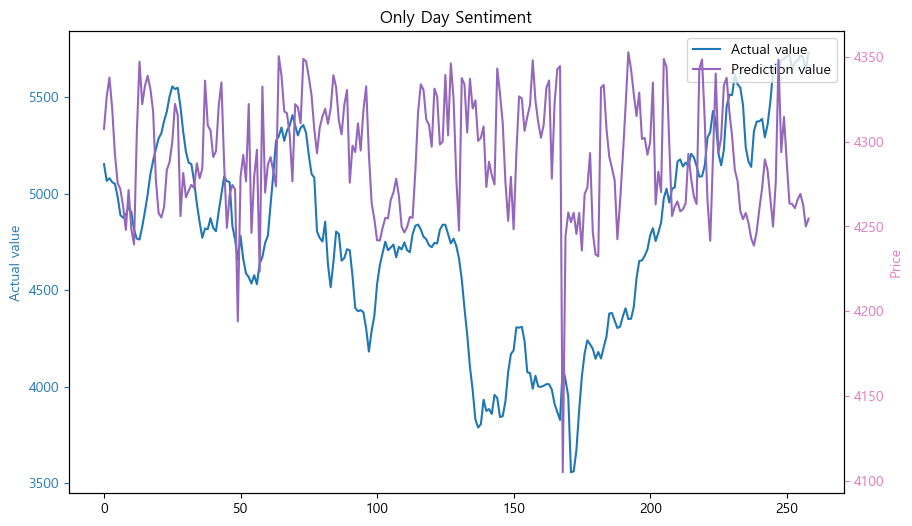

In [341]:
# 그래프 그리기

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
answer=np.mean(answer_np, axis=1)
prediction = np.mean(pred, axis=1)
# 선 그래프 그리기
ax.plot(np.arange(len(answer)), answer, label='Actual value',color="tab:blue", linestyle='-')

# 두 번째 축 (오른쪽)
ax2 = ax.twinx()
ax2.plot(np.arange(len(prediction)), prediction, label='Prediction value',color="tab:purple" , linestyle='-')


ax.set_ylabel('Actual value',color="#1f77b4")
ax2.set_ylabel('Prediction value', color='#e377c2')
ax.tick_params('y', colors='#1f77b4')
ax2.tick_params('y', colors='#e377c2')

# 그래프 레이블과 범례 추가
lines, labels = ax.get_legend_handles_labels()  # Get handles and labels for both lines
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')  # Combine and create a single legend

# 그래프 레이블과 범례 추가
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Only Day Sentiment')

# 날짜 눈금 조정
plt.xticks()

# 그래프 표시
plt.show()

# answer=np.mean(answer_np, axis=1)
# prediction = np.mean(pred, axis=1)

# plt.plot(np.arange(len(answer)), answer, label = 'true')
# plt.plot(np.arange(len(prediction)), prediction, label = 'pred')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.savefig("../결과/graph/{} {}train_size {}predict_size2.png".format(title,CFG['TRAIN_WINDOW_SIZE'],CFG['PREDICT_SIZE']), dpi=300)

## GRU TEST

In [342]:
# 모델선언

class BaseGRUModel(nn.Module):
    def __init__(self, input_size=CFG['how_inputdim'], hidden_size=CFG['hidden_dim'], output_size=CFG['PREDICT_SIZE']):
        super(BaseGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # GRU layer
        gru_out, hidden = self.gru(x, hidden)

        # Only use the last output sequence
        last_output = gru_out[:, -1, :]
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden stat
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
# 모델학습

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None

    for epoch in range(1, CFG['nb_epochs']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y.squeeze())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y.squeeze())

            val_loss.append(loss.item())
    return np.mean(val_loss)

model = BaseGRUModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

def inference(model, test_loader, device):
    model.eval()
    predictions=[]
    with torch.no_grad():
        for X, Y in tqdm(iter(test_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            predictions.extend(output)

    return np.array(predictions)

answer_np = np.empty((0,CFG['PREDICT_SIZE']))

for val in val_loader:
    answer_np = np.vstack((answer_np, val[1].view(-1,CFG['PREDICT_SIZE'])))

pred2 = inference(infer_model,val_loader , device)
print(pred2.shape)

pred2=scaler_y.inverse_transform(pred2)

# 눤래 정답을 inverse scaling

answer_np=scaler_y.inverse_transform(answer_np)    
# 결과 후처리
answer_np = np.round(answer_np, 0).astype(int)
print("answer_np", answer_np)

# 결과 출력
#MAE
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(answer_np, pred))
MAE_SCORE=MAE(answer_np, pred)

#MSE
from sklearn.metrics import mean_squared_error

print("MSE",mean_squared_error(answer_np,pred))
MSE=mean_squared_error(answer_np,pred)
#RMSE
import numpy as np
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(answer_np,pred)
print("RMSE",np.sqrt(MSE))
# sklearn 은 mse만 제공하기 때문에 rmse는 직접 만들어 써야한다.
RMSE=np.sqrt(MSE)
#MAPE
import numpy as np

def MAPE(y_test, y_pred):
    return np.mean(np.abs((answer_np - pred) / answer_np)) * 100

print("MAPE",MAPE(answer_np, pred))
MAPE_SCORE=MAPE(answer_np, pred)

#결과값 데이터프레임으로 저장
term_np=np.append(term_np,term)
MAE_np=np.append(MAE_np,MAE_SCORE )
MSE_np=np.append(MSE_np,MSE )
RMSE_np=np.append(RMSE_np,RMSE )
MAPE_np=np.append(MAPE_np,MAPE_SCORE )

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.16770] Val Loss : [0.23242]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.12068] Val Loss : [0.16696]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.09511] Val Loss : [0.11921]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.08100] Val Loss : [0.09290]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.07119] Val Loss : [0.08102]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.06989] Val Loss : [0.07403]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.06048] Val Loss : [0.06766]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.05684] Val Loss : [0.06334]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.06068] Val Loss : [0.06142]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.05330] Val Loss : [0.05959]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.05064] Val Loss : [0.05928]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.05104] Val Loss : [0.05801]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.04663] Val Loss : [0.05632]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.04472] Val Loss : [0.05247]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.04248] Val Loss : [0.05185]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.04389] Val Loss : [0.05353]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.04229] Val Loss : [0.05156]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.04355] Val Loss : [0.05023]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.04050] Val Loss : [0.04971]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.04174] Val Loss : [0.05011]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.04031] Val Loss : [0.04860]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.03732] Val Loss : [0.04776]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.03769] Val Loss : [0.04789]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.03972] Val Loss : [0.04812]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.03665] Val Loss : [0.04782]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.03633] Val Loss : [0.04675]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.03559] Val Loss : [0.04525]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.03583] Val Loss : [0.04446]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.03307] Val Loss : [0.04350]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.03451] Val Loss : [0.04395]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [31] Train Loss : [0.03510] Val Loss : [0.04450]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [32] Train Loss : [0.03475] Val Loss : [0.04486]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [33] Train Loss : [0.03344] Val Loss : [0.04305]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [34] Train Loss : [0.03358] Val Loss : [0.04252]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [35] Train Loss : [0.03342] Val Loss : [0.04261]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [36] Train Loss : [0.03512] Val Loss : [0.04284]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [37] Train Loss : [0.03340] Val Loss : [0.04308]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [38] Train Loss : [0.03349] Val Loss : [0.04263]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [39] Train Loss : [0.03321] Val Loss : [0.04260]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [40] Train Loss : [0.03255] Val Loss : [0.04153]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [41] Train Loss : [0.03221] Val Loss : [0.04073]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [42] Train Loss : [0.03197] Val Loss : [0.04051]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [43] Train Loss : [0.03206] Val Loss : [0.04064]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [44] Train Loss : [0.03147] Val Loss : [0.04086]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [45] Train Loss : [0.03150] Val Loss : [0.04046]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [46] Train Loss : [0.03231] Val Loss : [0.04090]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [47] Train Loss : [0.03213] Val Loss : [0.04107]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [48] Train Loss : [0.03014] Val Loss : [0.03980]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [49] Train Loss : [0.03227] Val Loss : [0.03963]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [50] Train Loss : [0.02994] Val Loss : [0.03972]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [51] Train Loss : [0.03099] Val Loss : [0.03969]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [52] Train Loss : [0.03068] Val Loss : [0.03932]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [53] Train Loss : [0.03070] Val Loss : [0.03913]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [54] Train Loss : [0.03007] Val Loss : [0.03915]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [55] Train Loss : [0.02949] Val Loss : [0.03853]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [56] Train Loss : [0.03017] Val Loss : [0.03855]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [57] Train Loss : [0.02991] Val Loss : [0.03860]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [58] Train Loss : [0.03069] Val Loss : [0.03915]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [59] Train Loss : [0.02990] Val Loss : [0.03865]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [60] Train Loss : [0.03006] Val Loss : [0.03822]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [61] Train Loss : [0.02993] Val Loss : [0.03780]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [62] Train Loss : [0.02990] Val Loss : [0.03755]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [63] Train Loss : [0.02950] Val Loss : [0.03773]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [64] Train Loss : [0.03018] Val Loss : [0.03832]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [65] Train Loss : [0.02953] Val Loss : [0.03813]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [66] Train Loss : [0.02986] Val Loss : [0.03810]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [67] Train Loss : [0.02940] Val Loss : [0.03744]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [68] Train Loss : [0.02919] Val Loss : [0.03651]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [69] Train Loss : [0.02939] Val Loss : [0.03663]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [70] Train Loss : [0.02926] Val Loss : [0.03695]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [71] Train Loss : [0.02913] Val Loss : [0.03675]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [72] Train Loss : [0.02905] Val Loss : [0.03702]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [73] Train Loss : [0.02918] Val Loss : [0.03706]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [74] Train Loss : [0.02882] Val Loss : [0.03671]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [75] Train Loss : [0.02845] Val Loss : [0.03625]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [76] Train Loss : [0.02906] Val Loss : [0.03625]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [77] Train Loss : [0.02868] Val Loss : [0.03646]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [78] Train Loss : [0.02921] Val Loss : [0.03692]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [79] Train Loss : [0.02893] Val Loss : [0.03645]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [80] Train Loss : [0.02853] Val Loss : [0.03579]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [81] Train Loss : [0.02871] Val Loss : [0.03559]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [82] Train Loss : [0.02874] Val Loss : [0.03613]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [83] Train Loss : [0.02850] Val Loss : [0.03634]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [84] Train Loss : [0.02890] Val Loss : [0.03642]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [85] Train Loss : [0.02864] Val Loss : [0.03650]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [86] Train Loss : [0.02908] Val Loss : [0.03631]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [87] Train Loss : [0.02849] Val Loss : [0.03617]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [88] Train Loss : [0.02826] Val Loss : [0.03547]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [89] Train Loss : [0.02876] Val Loss : [0.03571]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [90] Train Loss : [0.02840] Val Loss : [0.03585]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [91] Train Loss : [0.02823] Val Loss : [0.03580]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [92] Train Loss : [0.02823] Val Loss : [0.03556]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [93] Train Loss : [0.02829] Val Loss : [0.03549]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [94] Train Loss : [0.02832] Val Loss : [0.03521]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [95] Train Loss : [0.02815] Val Loss : [0.03514]
Model Saved


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [96] Train Loss : [0.02843] Val Loss : [0.03568]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [97] Train Loss : [0.02816] Val Loss : [0.03539]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [98] Train Loss : [0.02847] Val Loss : [0.03531]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [99] Train Loss : [0.02827] Val Loss : [0.03538]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch : [100] Train Loss : [0.02837] Val Loss : [0.03553]


  0%|          | 0/11 [00:00<?, ?it/s]

(259, 3)
answer_np [[5251 5108 5101]
 [5108 5101 4990]
 [5101 4990 5150]
 [4990 5150 5039]
 [5150 5039 4964]
 [5039 4964 4948]
 [4964 4948 4756]
 [4948 4756 4921]
 [4756 4921 4992]
 [4921 4992 4887]
 [4992 4887 4835]
 [4887 4835 4718]
 [4835 4718 4749]
 [4718 4749 4820]
 [4749 4820 4919]
 [4820 4919 4988]
 [4919 4988 5084]
 [4988 5084 5238]
 [5084 5238 5194]
 [5238 5194 5264]
 [5194 5264 5402]
 [5264 5402 5274]
 [5402 5274 5454]
 [5274 5454 5549]
 [5454 5549 5507]
 [5549 5507 5611]
 [5507 5611 5509]
 [5611 5509 5527]
 [5509 5527 5317]
 [5527 5317 5118]
 [5317 5118 5216]
 [5118 5216 5148]
 [5216 5148 5095]
 [5148 5095 4944]
 [5095 4944 4806]
 [4944 4806 4810]
 [4806 4810 4699]
 [4810 4699 4950]
 [4699 4950 4799]
 [4950 4799 4870]
 [4799 4870 4798]
 [4870 4798 4749]
 [4798 4749 5176]
 [4749 5176 5069]
 [5176 5069 5022]
 [5069 5022 5105]
 [5022 5105 5052]
 [5105 5052 4345]
 [5052 4345 4891]
 [4345 4891 4734]
 [4891 4734 4717]
 [4734 4717 4531]
 [4717 4531 4513]
 [4531 4513 4658]
 [4513 46

In [343]:
#prediction2=data2 = np.load('./prediction2.npy') # 데이터 로드. @파일명

In [344]:
# 그래프 그리기
answer=np.mean(answer_np, axis=1)
GRU_prediction = np.mean(pred2, axis=1)

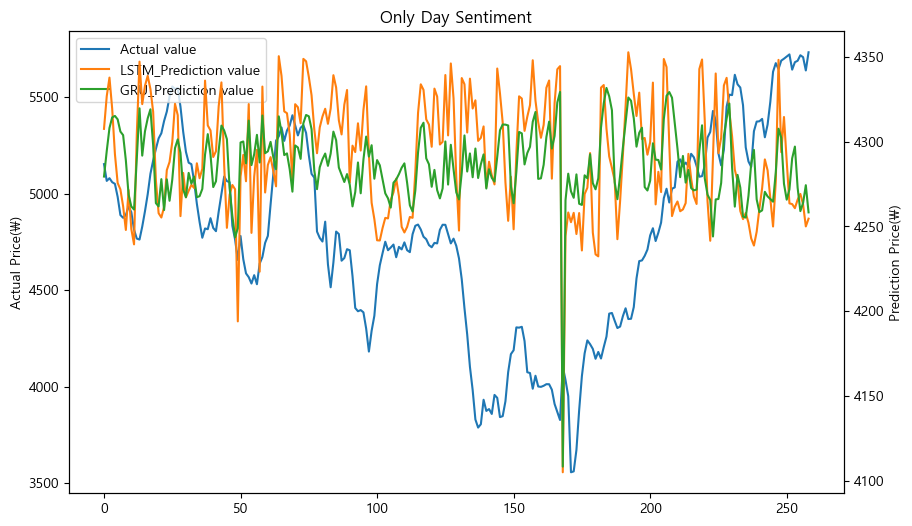

In [345]:
# 그래프 그리기

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
answer=np.mean(answer_np, axis=1)
prediction = np.mean(pred, axis=1)
# 선 그래프 그리기
ax.plot(np.arange(len(answer)), answer, label='Actual value',color="tab:blue", linestyle='-')

# 두 번째 축 (오른쪽)
ax2 = ax.twinx()
ax2.plot(np.arange(len(prediction)), prediction, label='LSTM_Prediction value',color="tab:orange" , linestyle='-')
ax2.plot(np.arange(len(GRU_prediction)), GRU_prediction, label='GRU_Prediction value',color="tab:green",linestyle='-')
ax.set_ylabel('Actual Price(\)')
ax2.set_ylabel('Prediction Price(\)')
ax.tick_params('y')
ax2.tick_params('y')

# 그래프 레이블과 범례 추가
lines, labels = ax.get_legend_handles_labels()  # Get handles and labels for both lines
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')  # Combine and create a single legend

# 그래프 레이블과 범례 추가
plt.xlabel('Date')
#plt.ylabel('Price(\)')
plt.title('Only Day Sentiment')

# 날짜 눈금 조정
plt.xticks()

# 그래프 표시
plt.show()